# Winter Optimization problem

This research project aims to address the concerns of Montréal residents regarding snowplowing operations while considering the delicate issue of increasing the allocated funds. The objective is to minimize the cost of a typical snowplowing day by finding an efficient and cost-effective path for snowplows around the Montréal road network. Additionally, a drone-based aerial analysis will be performed to identify the sectors requiring immediate snowplowing. The report provides a summary of the data used, the study perimeter, hypotheses, model choices, selected solutions, cost model for snow removal operations, and limitations of the proposed model.

Step 1: We will begin by providing a comprehensive theoretical overview, outlining the necessary prerequisites to understand our proposed solution.

Step 2: Next, we will introduce the reconnaissance phase, utilizing a drone capable of unrestricted navigation throughout a selected neighborhood in Montreal.

Step 3: Following the reconnaissance, we will apply the same approach to the snowplow model, ensuring efficient and effective snow removal.

Step 4: Lastly, we will conclude by briefly discussing the important aspect of scaling up the snow removal operations citywide in Montreal.

# Clearing Snow in Montreal

##### Importing python packages

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import math

##### Loading a district with all the networks

In [29]:
G = ox.graph_from_place('Alert, Nunavut', network_type='all')
G = ox.get_undirected(G)

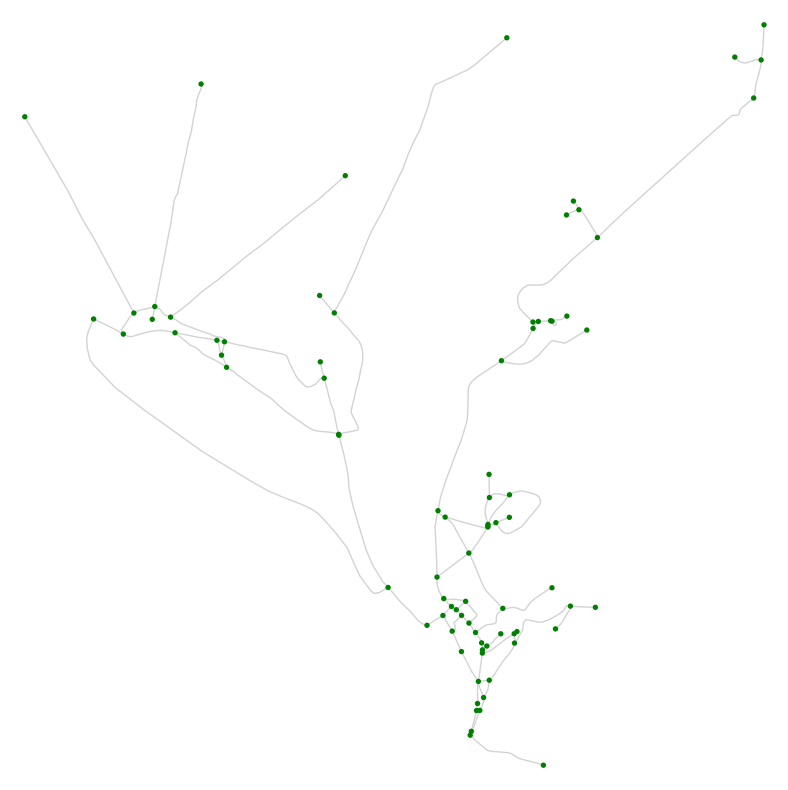

In [30]:
node_color = ["gray" if "highway" in data and "footway" not in data["highway"] else "green" for _, data in G.nodes(data=True)]
edge_color = ["lightgray" if "highway" in data and "footway" not in data["highway"] else "darkgreen" for _, _, data in G.edges(data=True)]

ox.plot_graph(G, node_color=node_color, edge_color=edge_color, bgcolor='white', figsize=(10, 10), show = True)
plt.show()

##### Loading the district with only the road networks

In [31]:
G = ox.graph_from_place('Alert, Nunavut', network_type='drive')
G = ox.get_undirected(G)

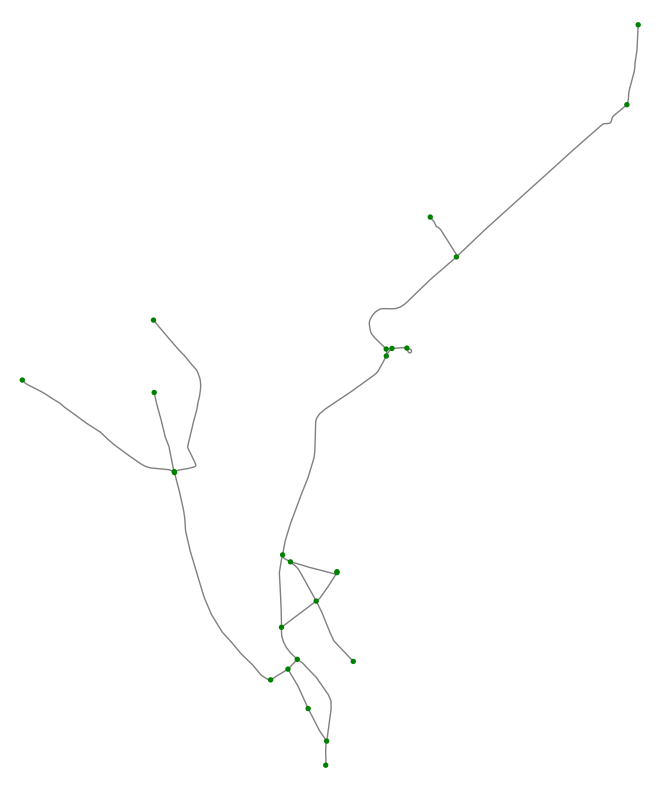

In [32]:
fig, ax = ox.plot_graph(G, node_color="green", edge_color="gray", bgcolor='white', figsize=(10, 10), show=True)
plt.show()

This graph represents the road network of a district in montreal.

Now that we have the road network, and the graph of the district as a multigraph, in order to traverse all the edges at least once, the graph needs to be eulerian. In most cases it's not, let's check if it is for this case.

In [33]:
print("Is the graph eulerian?", nx.is_eulerian(G))

Is the graph eulerian? False


So our goal now is to make the graph eulerian.

In [34]:
degrees = G.degree()
odd_degree_nodes = [node for node, degree in dict(degrees).items() if degree % 2 != 0]
G_odd_complete = nx.complete_graph(odd_degree_nodes)
odd_matching = nx.algorithms.max_weight_matching(G_odd_complete, maxcardinality=True)
G.add_edges_from(odd_matching)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Let's now make sure if the graph is eulerian

In [35]:
print("Is the graph eulerian?", nx.is_eulerian(G))

Is the graph eulerian? True


Now that our graph is eulerian, let's display how it looks like.

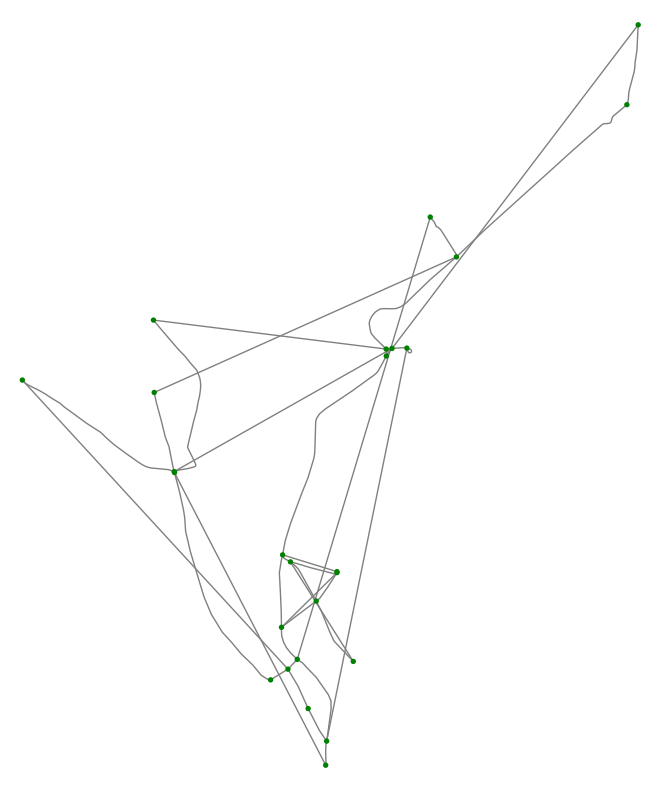

In [36]:
ox.plot_graph(G, node_color="green", edge_color="gray", bgcolor='white', figsize=(10, 10), show=True)
plt.show()

We just face one issue now. The edges we added to the graph don't have a length. Let's add that.

In [37]:
def add_weights_to_edges(G):
    for u, v, d in G.edges(data=True):
        if 'length' not in d:
            weight = nx.dijkstra_path_length(G, u, v, weight='length')
            d["length"] = weight
    return G

add_weights_to_edges(G)

Summary for step 1: We got a small graph of a part of canada for our test, we checked if it was eulerian which is very unlikely for it to be. Since it's not eulerian we make it eulerian. After making it eulerian, we add the lengths to the new edges.

# STEP 2

Now that our graph is Eulerian, all we need to do is find a cycle to represent the path the drone will take.

In [38]:
euler_circuit = list(nx.eulerian_circuit(G, source=next(iter(G))))

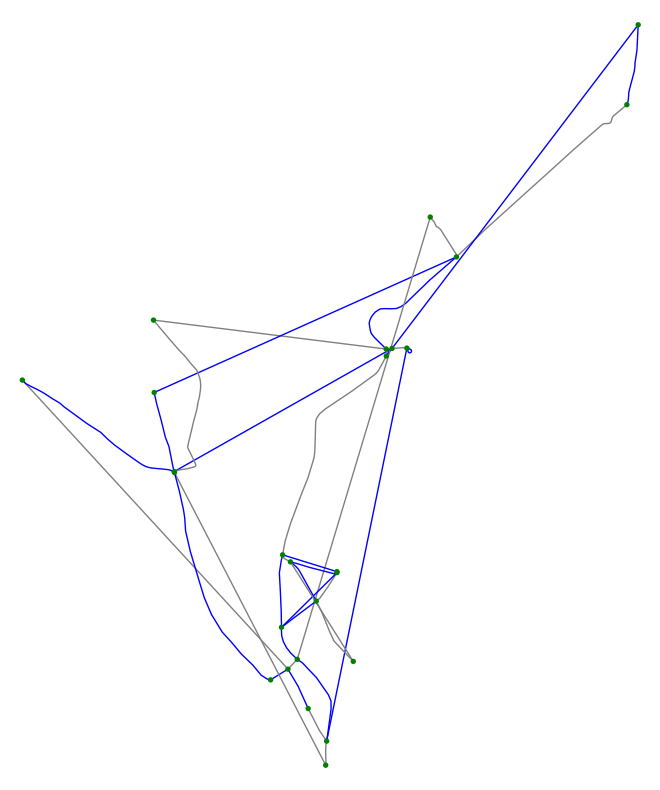

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [39]:
edge_colors = ["blue" if edge in euler_circuit else "grey" for edge in G.edges()]
ox.plot_graph(G, node_color="green", edge_color=edge_colors, bgcolor='white', figsize=(10, 10), show=True)

The blue edges represent a eulerian cycle which is a path the drone should take.

In [40]:
total_distance_km = sum(nx.path_weight(G, (u, v), weight='length') for (u, v) in euler_circuit) / 1000
print("Total distance of the Eulerian circuit:", total_distance_km, "km")

Total distance of the Eulerian circuit: 9.542273999999999 km


# Step 3

The same logic can be applied to the snowplows. The main difference is that for the calculation of the snowplows, the graph should be directed.

In [41]:
G = G.to_directed()

In [42]:
print("Is the graph eulerian?", nx.is_eulerian(G))

Is the graph eulerian? True


Since our graph is already eulerian, as we applied this before, all we have to do now is find a eulerian circuit.

In [43]:
euler_circuit = list(nx.eulerian_circuit(G, source=next(iter(G))))

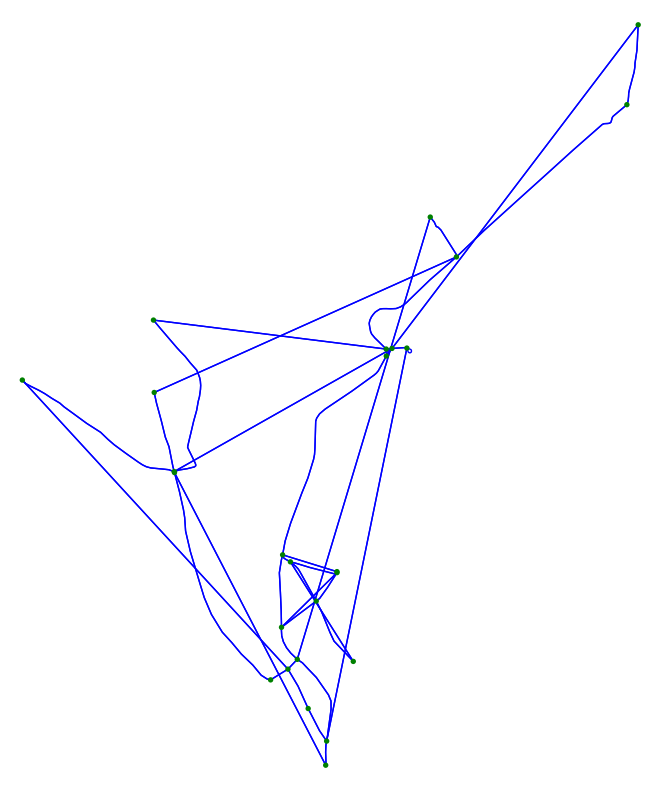

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [44]:
edge_colors = ["blue" if edge in euler_circuit else "grey" for edge in G.edges()]
ox.plot_graph(G, node_color="green", edge_color=edge_colors, bgcolor='white', figsize=(10, 10), show=True)

We can observe from this drawing that the snowplow will pass through the entire graph. And since this is a eulerian circuit calculated based on weight (length in our case). Then the route found by the eulerian circuit is the most optimized route to take.

In [45]:
total_distance_km = sum(nx.path_weight(G, (u, v), weight='length') for (u, v) in euler_circuit) / 1000
print("Total distance of the Eulerian circuit:", total_distance_km, "km")

Total distance of the Eulerian circuit: 19.017214000000006 km


We can observe that the distance traversed by the snowplows is larger than the distance traversed by the drones.

This logic can be applied to the city of Montréal which will take a lot of computational time to be able to do in this demo.

# Conclusion

Doing the previous step on the selected districts of Montreal allowed us to find the distances traversed by the drone and the snowplows which are the following.

| District                             | Drone (km) | Snowplows (km) |
|--------------------------------------|------------|----------------|
| Outremont                            | 44.5       | 89             |
| Verdun                               | 72.3       | 144.49         |
| Saint-Léonard                        | 181.68     | 362.79         |
| Rivière-des-prairies-pointe-aux-trembles | 424.13     | 844.46         |
| Le Plateau-Mont-Royal                | 134.29     | 268.42         |

Using these distances, we can compute the costs.

We suppose that the drone can go 8km per hour and its working hours are 2 hours per day. Knowing that, we can calculate the costs.

| District                             | Drones | Drone Cost | Snowplow I | Snowplow II | Snowplows Cost ($)|
|--------------------------------------|------------|----------------|----------------|----------------|----------------|
| Outremont                            | 3 | 300.48     | 1           | 0 | 607.87 |
| Verdun                               | 5 | 500.79       | 0       | 1 | 997.22885 |
| Saint-Léonard                        | 12 | 1201.92    |0        | 2 | 2095.63625 |
| Rivière-des-prairies-pointe-aux-trembles | 27 |2704.31     | 0         | 4 |  4354.7325 |
| Le Plateau-Mont-Royal                | 9 |901.43     | 1         | 1 | 1652.90387 |

Finally, the total costs for both drones and snowplows is 15,317.30147 $